In [37]:
# ESG Scoring using BERT Model
# Following Exercise methodology and evaluating against benchmark

import pandas as pd
import numpy as np
import os
import json
from transformers import pipeline, AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")
print("BERT ESG Analysis Setup Complete")
print("=" * 50)

Using device: CPU
BERT ESG Analysis Setup Complete


In [38]:
# 1. Load and Prepare ESG Data (Following Exercise Methodology)

def load_benchmark_scores():
    """Load benchmark ESG scores from benchMark.md"""
    benchmark_scores = {
        'Nike': 70, 'Apple': 70, 'Boeing': 79, 'Disney': 68, 'Eli Lilly': 64, 'FedEx': 71,
        'Johnson & Johnson': 85, 'JPMorgan Chase': 80, 'McDonald\'s': 66, 'Meta': 60,
        'Microsoft': 87, 'Netflix': 37, 'NVIDIA': 77, 'Tesla': 72, 'Google': 81
    }
    return benchmark_scores

def load_company_documents():
    """Load all ESG-related documents for each company"""
    data_path = "data"
    company_texts = {}
    
    # Company directory mapping
    company_dirs = {
        'Nike': 'nike', 'Apple': 'apple', 'Boeing': 'boeing', 'Disney': 'disney',
        'Eli Lilly': 'elililly', 'FedEx': 'fedex', 'Johnson & Johnson': 'johnsonandjohnson',
        'JPMorgan Chase': 'jpmorganchase', 'McDonald\'s': 'mcdonald', 'Meta': 'meta',
        'Microsoft': 'microsoft', 'Netflix': 'netflix', 'NVIDIA': 'nvidia',
        'Tesla': 'tesla', 'Google': 'google'
    }
    
    print("Loading company documents...")
    for company, dir_name in company_dirs.items():
        company_path = os.path.join(data_path, dir_name)
        if os.path.exists(company_path):
            all_text = ""
            file_count = 0
            
            # Load all relevant files
            for file in os.listdir(company_path):
                if file.endswith(('.md', '.txt')):
                    file_path = os.path.join(company_path, file)
                    try:
                        with open(file_path, 'r', encoding='utf-8') as f:
                            content = f.read()
                            # Truncate very long documents for BERT processing
                            if len(content) > 50000:  # Limit for BERT processing
                                content = content[:50000]
                            all_text += content + " "
                            file_count += 1
                    except Exception as e:
                        print(f"Error reading {file_path}: {e}")
            
            if all_text.strip():
                company_texts[company] = all_text.strip()
                print(f"✓ {company}: {file_count} files, {len(all_text)} characters")
            else:
                print(f"✗ {company}: No text found")
        else:
            print(f"✗ {company}: Directory not found - {company_path}")
    
    return company_texts

# Load data
benchmark_scores = load_benchmark_scores()
company_texts = load_company_documents()

print(f"\nLoaded data for {len(company_texts)} companies")
print(f"Benchmark scores available for {len(benchmark_scores)} companies")

# Create dataset
data = []
for company in company_texts.keys():
    if company in benchmark_scores:
        data.append({
            'company': company,
            'text': company_texts[company],
            'esg_score': benchmark_scores[company]
        })

esg_df = pd.DataFrame(data)
print(f"\nFinal dataset: {len(esg_df)} companies with both text and scores")
print(esg_df[['company', 'esg_score']].head())

Loading company documents...
✓ Nike: 5 files, 195218 characters
✓ Apple: 5 files, 132840 characters
✓ Boeing: 5 files, 170027 characters
✓ Disney: 5 files, 205533 characters
✓ Eli Lilly: 5 files, 200317 characters
✓ FedEx: 5 files, 205062 characters
✓ Johnson & Johnson: 5 files, 133248 characters
✓ JPMorgan Chase: 5 files, 141135 characters
✓ McDonald's: 5 files, 50248 characters
✓ Meta: 5 files, 196477 characters
✓ Microsoft: 5 files, 199364 characters
✓ Netflix: 5 files, 147484 characters
✓ NVIDIA: 5 files, 188603 characters
✓ Tesla: 5 files, 155647 characters
✓ Google: 5 files, 174319 characters

Loaded data for 15 companies
Benchmark scores available for 15 companies

Final dataset: 15 companies with both text and scores
     company  esg_score
0       Nike         70
1      Apple         70
2     Boeing         79
3     Disney         68
4  Eli Lilly         64


In [39]:
# 2. Create ESG Score Categories (Following Exercise Methodology)

def create_esg_categories(df):
    """Create categorical labels from continuous ESG scores"""
    
    # Create quartile-based categories
    df['esg_quartile'] = pd.qcut(df['esg_score'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    
    # Create three-tier categorization
    df['esg_tier'] = pd.cut(df['esg_score'], 
                           bins=[0, 50, 75, 100], 
                           labels=['Poor', 'Good', 'Excellent'],
                           include_lowest=True)
    
    # Create binary classification (above/below median)
    median_score = df['esg_score'].median()
    df['esg_binary'] = df['esg_score'].apply(lambda x: 'High' if x >= median_score else 'Low')
    
    print("ESG Score Distribution:")
    print(f"Range: {df['esg_score'].min()} - {df['esg_score'].max()}")
    print(f"Mean: {df['esg_score'].mean():.1f}")
    print(f"Median: {median_score:.1f}")
    print(f"Std: {df['esg_score'].std():.1f}")
    
    print("\nCategory Distributions:")
    print("Quartiles:")
    print(df['esg_quartile'].value_counts().sort_index())
    print("\nTiers:")
    print(df['esg_tier'].value_counts().sort_index())
    print("\nBinary:")
    print(df['esg_binary'].value_counts())
    
    return df

# Apply categorization
esg_df = create_esg_categories(esg_df)

# Display sample
print("\nSample data with categories:")
print(esg_df[['company', 'esg_score', 'esg_quartile', 'esg_tier', 'esg_binary']].head(10))

ESG Score Distribution:
Range: 37 - 87
Mean: 71.1
Median: 71.0
Std: 12.2

Category Distributions:
Quartiles:
esg_quartile
Low            4
Medium-Low     4
Medium-High    3
High           4
Name: count, dtype: int64

Tiers:
esg_tier
Poor         1
Good         8
Excellent    6
Name: count, dtype: int64

Binary:
esg_binary
High    8
Low     7
Name: count, dtype: int64

Sample data with categories:
             company  esg_score esg_quartile   esg_tier esg_binary
0               Nike         70   Medium-Low       Good        Low
1              Apple         70   Medium-Low       Good        Low
2             Boeing         79  Medium-High  Excellent       High
3             Disney         68   Medium-Low       Good        Low
4          Eli Lilly         64          Low       Good        Low
5              FedEx         71   Medium-Low       Good       High
6  Johnson & Johnson         85         High  Excellent       High
7     JPMorgan Chase         80         High  Excellent       Hi

In [40]:
# 3. BERT Embeddings Extraction (Following Exercise Methodology)

def setup_bert_embedder():
    """
    Setup BERT embedder following exercise methodology
    Using ModernBERT as in the exercise
    """
    print("Setting up BERT embedder...")
    
    try:
        # Try ModernBERT first (as in exercise)
        embedder = pipeline(
            model="answerdotai/ModernBERT-base",
            tokenizer="answerdotai/ModernBERT-base", 
            task="feature-extraction",
            device=device,
            return_tensors="pt",  # Return PyTorch tensors
            truncation=True,
            padding=True,
            max_length=512  # Standard BERT max length
        )
        model_name = "ModernBERT-base"
        print(f"✓ Using {model_name}")
    except Exception as e:
        print(f"ModernBERT not available: {e}")
        # Fallback to BERT-base
        try:
            embedder = pipeline(
                model="bert-base-uncased",
                task="feature-extraction",
                device=device,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=512
            )
            model_name = "bert-base-uncased"
            print(f"✓ Using fallback {model_name}")
        except Exception as e:
            print(f"Error setting up BERT: {e}")
            return None, None
    
    return embedder, model_name

def get_bert_embeddings(texts, embedder, batch_size=1):
    """
    Extract BERT embeddings following exercise methodology
    Returns CLS token embeddings as in the exercise
    """
    print(f"Extracting BERT embeddings for {len(texts)} texts...")
    
    embeddings = []
    for i, text in enumerate(texts):
        try:
            # Truncate text if too long for BERT (512 tokens is BERT's typical limit)
            # For very long texts, take first 2000 characters as approximation
            if len(text) > 2000:
                text = text[:2000]
            
            # Get embeddings
            result = embedder(text)
            
            # Debug: Print the structure of the result for first text
            if i == 0:
                print(f"Debug - Result type: {type(result)}")
                if isinstance(result, (list, tuple)) and len(result) > 0:
                    print(f"Debug - First element type: {type(result[0])}")
                    print(f"Debug - First element shape: {getattr(result[0], 'shape', 'No shape attribute')}")
            
            # Extract CLS token embedding (first token) - Handle different output formats
            cls_embedding = None
            
            if isinstance(result, list) and len(result) > 0:
                # Case 1: List of tensors/arrays
                first_element = result[0]
                if hasattr(first_element, 'shape') and len(first_element.shape) >= 2:
                    # Get first token ([CLS]) embedding: shape should be [seq_len, hidden_dim]
                    cls_embedding = first_element[0]  # First token
                elif hasattr(first_element, 'shape') and len(first_element.shape) == 3:
                    # Shape might be [batch, seq_len, hidden_dim]
                    cls_embedding = first_element[0][0]  # First batch, first token
            elif hasattr(result, 'shape'):
                # Case 2: Direct tensor/array
                if len(result.shape) == 2:
                    cls_embedding = result[0]  # First token
                elif len(result.shape) == 3:
                    cls_embedding = result[0][0]  # First batch, first token
            
            # Convert to numpy if needed
            if cls_embedding is not None:
                if hasattr(cls_embedding, 'numpy'):
                    cls_embedding = cls_embedding.numpy()
                elif hasattr(cls_embedding, 'detach'):
                    cls_embedding = cls_embedding.detach().numpy()
                embeddings.append(cls_embedding)
            else:
                print(f"Warning: Could not extract embedding for text {i}, using zero embedding")
                embeddings.append(np.zeros(768))  # Standard BERT embedding size
            
            if (i + 1) % 5 == 0:
                print(f"  Processed {i + 1}/{len(texts)} texts")
                
        except Exception as e:
            print(f"Error processing text {i}: {e}")
            # Use zero embedding as fallback
            embeddings.append(np.zeros(768))
    
    embeddings_array = np.array(embeddings)
    print(f"✓ Extracted embeddings shape: {embeddings_array.shape}")
    
    # Check if we got mostly zero embeddings
    non_zero_count = np.count_nonzero(embeddings_array.sum(axis=1))
    print(f"✓ Non-zero embeddings: {non_zero_count}/{len(embeddings_array)}")
    
    return embeddings_array

# Setup BERT embedder
embedder, model_name = setup_bert_embedder()

if embedder is not None:
    # Extract embeddings for all company texts
    company_texts_list = esg_df['text'].tolist()
    bert_embeddings = get_bert_embeddings(company_texts_list, embedder)
    
    # Add embeddings to dataframe
    esg_df['bert_embeddings'] = bert_embeddings.tolist()
    
    print(f"\nBERT embeddings extracted successfully!")
    print(f"Using model: {model_name}")
    print(f"Embedding dimension: {bert_embeddings.shape[1]}")
else:
    print("Failed to setup BERT embedder")

Setting up BERT embedder...


Device set to use cpu


✓ Using ModernBERT-base
Extracting BERT embeddings for 15 texts...
Debug - Result type: <class 'torch.Tensor'>
  Processed 5/15 texts
  Processed 10/15 texts
  Processed 15/15 texts
✓ Extracted embeddings shape: (15, 768)
✓ Non-zero embeddings: 15/15

BERT embeddings extracted successfully!
Using model: ModernBERT-base
Embedding dimension: 768


In [41]:
# 4. Train-Test Split (Following Exercise Methodology)

def prepare_bert_train_test_split(df, test_size=0.3, random_state=777):
    """
    Prepare train-test split for BERT embeddings following exercise methodology
    """
    
    # Extract features and targets
    X = np.array(df['bert_embeddings'].tolist())  # BERT embeddings
    y_regression = df['esg_score'].values
    y_quartile = df['esg_quartile'].values
    y_tier = df['esg_tier'].values
    y_binary = df['esg_binary'].values
    companies = df['company'].values
    
    # Create splits
    X_train, X_test, y_reg_train, y_reg_test = train_test_split(
        X, y_regression, test_size=test_size, random_state=random_state
    )
    
    # Split other target variables maintaining same indices
    indices = np.arange(len(X))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, random_state=random_state
    )
    
    y_quartile_train = y_quartile[train_indices]
    y_quartile_test = y_quartile[test_indices]
    
    y_tier_train = y_tier[train_indices]
    y_tier_test = y_tier[test_indices]
    
    y_binary_train = y_binary[train_indices]
    y_binary_test = y_binary[test_indices]
    
    companies_train = companies[train_indices]
    companies_test = companies[test_indices]
    
    print(f"BERT Dataset split:")
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    print(f"Feature dimension: {X_train.shape[1]}")
    
    print(f"\nTraining set score distribution:")
    print(f"ESG scores: {y_reg_train.min():.0f} - {y_reg_train.max():.0f} (mean: {y_reg_train.mean():.1f})")
    
    print(f"\nTest set score distribution:")
    print(f"ESG scores: {y_reg_test.min():.0f} - {y_reg_test.max():.0f} (mean: {y_reg_test.mean():.1f})")
    
    print(f"\nTraining companies: {companies_train.tolist()}")
    print(f"Test companies: {companies_test.tolist()}")
    
    return (X_train, X_test, 
            y_reg_train, y_reg_test,
            y_quartile_train, y_quartile_test,
            y_tier_train, y_tier_test,
            y_binary_train, y_binary_test,
            companies_train, companies_test)

# Create train-test split for BERT
if 'bert_embeddings' in esg_df.columns:
    (X_train, X_test, 
     y_reg_train, y_reg_test,
     y_quartile_train, y_quartile_test,
     y_tier_train, y_tier_test,
     y_binary_train, y_binary_test,
     companies_train, companies_test) = prepare_bert_train_test_split(esg_df)
    
    print(f"\nCheck X_train shape: {X_train.shape}, y_train shape: {y_reg_train.shape}")
    print(f"Check X_test shape: {X_test.shape}, y_test shape: {y_reg_test.shape}")
else:
    print("BERT embeddings not available - skipping train-test split")

BERT Dataset split:
Training set: 10 samples
Test set: 5 samples
Feature dimension: 768

Training set score distribution:
ESG scores: 37 - 87 (mean: 71.5)

Test set score distribution:
ESG scores: 66 - 77 (mean: 70.4)

Training companies: ['Boeing', 'Microsoft', 'Meta', 'Eli Lilly', 'Tesla', 'Apple', 'Google', 'Johnson & Johnson', 'Netflix', 'JPMorgan Chase']
Test companies: ["McDonald's", 'NVIDIA', 'FedEx', 'Disney', 'Nike']

Check X_train shape: (10, 768), y_train shape: (10,)
Check X_test shape: (5, 768), y_test shape: (5,)


In [42]:
# 5. Classification Models with BERT (Following Exercise Methodology)

def train_bert_classification_models(X_train, X_test, y_train, y_test, task_name):
    """
    Train classification models with BERT embeddings following exercise methodology
    """
    
    print(f"\n{task_name} Classification with BERT Embeddings")
    print("=" * 60)
    
    results = {}
    
    # Logistic Regression (as in exercise)
    print("Training Logistic Regression...")
    lr_clf = LogisticRegression(max_iter=1000, random_state=777)
    lr_clf.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = lr_clf.predict(X_train)
    y_test_pred = lr_clf.predict(X_test)
    
    print("Logistic Regression Results:")
    print("\nTraining Set Performance:")
    print(classification_report(y_train, y_train_pred))
    
    print("Test Set Performance:")
    print(classification_report(y_test, y_test_pred))
    
    results['LogisticRegression'] = {
        'model': lr_clf,
        'train_pred': y_train_pred,
        'test_pred': y_test_pred
    }
    
    # Random Forest (additional model)
    print("\nTraining Random Forest...")
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=777)
    rf_clf.fit(X_train, y_train)
    
    y_train_pred_rf = rf_clf.predict(X_train)
    y_test_pred_rf = rf_clf.predict(X_test)
    
    print("Random Forest Results:")
    print("\nTraining Set Performance:")
    print(classification_report(y_train, y_train_pred_rf))
    
    print("Test Set Performance:")
    print(classification_report(y_test, y_test_pred_rf))
    
    results['RandomForest'] = {
        'model': rf_clf,
        'train_pred': y_train_pred_rf,
        'test_pred': y_test_pred_rf
    }
    
    return results

# Train classification models if BERT embeddings are available
if 'X_train' in locals():
    # Binary classification
    print("BINARY ESG CLASSIFICATION WITH BERT")
    binary_bert_results = train_bert_classification_models(
        X_train, X_test, y_binary_train, y_binary_test,
        "Binary ESG"
    )
    
    # Tier classification  
    tier_bert_results = train_bert_classification_models(
        X_train, X_test, y_tier_train, y_tier_test,
        "Tier ESG"
    )
else:
    print("Skipping classification - BERT embeddings not available")

BINARY ESG CLASSIFICATION WITH BERT

Binary ESG Classification with BERT Embeddings
Training Logistic Regression...
Logistic Regression Results:

Training Set Performance:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         6
         Low       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Test Set Performance:
              precision    recall  f1-score   support

        High       0.50      1.00      0.67         2
         Low       1.00      0.33      0.50         3

    accuracy                           0.60         5
   macro avg       0.75      0.67      0.58         5
weighted avg       0.80      0.60      0.57         5


Training Random Forest...
Random Forest Results:

Training Set Performance:
              precision    recall  f1-score   support

        High       1

In [43]:
# 6. Regression Models with BERT Embeddings

def train_bert_regression_models(X_train, X_test, y_train, y_test):
    """
    Train regression models with BERT embeddings for continuous ESG score prediction
    """
    
    print(f"\nESG Score Regression with BERT Embeddings")
    print("=" * 60)
    
    results = {}
    
    # Linear Regression (as in exercise style)
    print("Training Linear Regression...")
    lr_reg = LinearRegression()
    lr_reg.fit(X_train, y_train)
    
    y_train_pred = lr_reg.predict(X_train)
    y_test_pred = lr_reg.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print("Linear Regression:")
    print(f"  Training: MAE={train_mae:.2f}, R²={train_r2:.4f}")
    print(f"  Test: MAE={test_mae:.2f}, R²={test_r2:.4f}")
    
    results['LinearRegression'] = {
        'model': lr_reg,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_pred': y_train_pred,
        'test_pred': y_test_pred
    }
    
    # Ridge Regression
    print("\nTraining Ridge Regression...")
    ridge_reg = Ridge(alpha=1.0, random_state=777)
    ridge_reg.fit(X_train, y_train)
    
    y_train_pred_ridge = ridge_reg.predict(X_train)
    y_test_pred_ridge = ridge_reg.predict(X_test)
    
    train_mae_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
    test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
    train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
    test_r2_ridge = r2_score(y_test, y_test_pred_ridge)
    
    print("Ridge Regression:")
    print(f"  Training: MAE={train_mae_ridge:.2f}, R²={train_r2_ridge:.4f}")
    print(f"  Test: MAE={test_mae_ridge:.2f}, R²={test_r2_ridge:.4f}")
    
    results['RidgeRegression'] = {
        'model': ridge_reg,
        'train_mae': train_mae_ridge,
        'test_mae': test_mae_ridge,
        'train_r2': train_r2_ridge,
        'test_r2': test_r2_ridge,
        'train_pred': y_train_pred_ridge,
        'test_pred': y_test_pred_ridge
    }
    
    # Random Forest Regression
    print("\nTraining Random Forest Regression...")
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=777)
    rf_reg.fit(X_train, y_train)
    
    y_train_pred_rf = rf_reg.predict(X_train)
    y_test_pred_rf = rf_reg.predict(X_test)
    
    train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
    test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
    train_r2_rf = r2_score(y_train, y_train_pred_rf)
    test_r2_rf = r2_score(y_test, y_test_pred_rf)
    
    print("Random Forest Regression:")
    print(f"  Training: MAE={train_mae_rf:.2f}, R²={train_r2_rf:.4f}")
    print(f"  Test: MAE={test_mae_rf:.2f}, R²={test_r2_rf:.4f}")
    
    results['RandomForestRegression'] = {
        'model': rf_reg,
        'train_mae': train_mae_rf,
        'test_mae': test_mae_rf,
        'train_r2': train_r2_rf,
        'test_r2': test_r2_rf,
        'train_pred': y_train_pred_rf,
        'test_pred': y_test_pred_rf
    }
    
    return results

# Train regression models if BERT embeddings are available
if 'X_train' in locals():
    bert_reg_results = train_bert_regression_models(X_train, X_test, y_reg_train, y_reg_test)
else:
    print("Skipping regression - BERT embeddings not available")


ESG Score Regression with BERT Embeddings
Training Linear Regression...
Linear Regression:
  Training: MAE=0.00, R²=1.0000
  Test: MAE=10.32, R²=-10.2044

Training Ridge Regression...
Ridge Regression:
  Training: MAE=0.50, R²=0.9977
  Test: MAE=10.12, R²=-9.7855

Training Random Forest Regression...


Random Forest Regression:
  Training: MAE=3.92, R²=0.8917
  Test: MAE=4.46, R²=-0.7776


In [44]:
# 7. Comprehensive Evaluation Against Benchmark

def evaluate_bert_against_benchmark():
    """
    Use the best performing BERT model to predict ESG scores for all companies
    and evaluate against benchmark scores
    """
    
    print("\nEVALUATING BERT MODEL AGAINST BENCHMARK")
    print("=" * 60)
    
    # Check if BERT regression results are available
    if 'bert_reg_results' not in globals():
        print("Error: BERT regression results not available")
        return None, None, None, None, None, None
    
    # Find best model based on test R² score
    best_model_type = None
    best_r2 = -float('inf')
    best_model = None
    
    global bert_reg_results
    for model_name, results in bert_reg_results.items():
        if results['test_r2'] > best_r2:
            best_r2 = results['test_r2']
            best_model_type = model_name
            best_model = results['model']
    
    print(f"Best BERT model: {best_model_type}")
    print(f"Best test R²: {best_r2:.4f}")
    
    # Predict for all companies using BERT embeddings
    all_embeddings = np.array(esg_df['bert_embeddings'].tolist())
    all_companies = esg_df['company'].tolist()
    actual_scores = esg_df['esg_score'].tolist()
    
    # Get predictions from best model
    predicted_scores = best_model.predict(all_embeddings)
    
    # Create evaluation dataframe
    evaluation_data = []
    for i, company in enumerate(all_companies):
        evaluation_data.append({
            'Company': company,
            'Benchmark_Score': actual_scores[i],
            'BERT_Predicted': predicted_scores[i],
            'Error': predicted_scores[i] - actual_scores[i],
            'Abs_Error': abs(predicted_scores[i] - actual_scores[i])
        })
    
    eval_df = pd.DataFrame(evaluation_data)
    eval_df = eval_df.sort_values('Benchmark_Score')
    
    # Calculate overall metrics
    mae_overall = mean_absolute_error(eval_df['Benchmark_Score'], eval_df['BERT_Predicted'])
    rmse_overall = np.sqrt(mean_squared_error(eval_df['Benchmark_Score'], eval_df['BERT_Predicted']))
    r2_overall = r2_score(eval_df['Benchmark_Score'], eval_df['BERT_Predicted'])
    
    print(f"\nOVERALL PERFORMANCE METRICS:")
    print(f"Mean Absolute Error (MAE): {mae_overall:.2f}")
    print(f"Root Mean Square Error (RMSE): {rmse_overall:.2f}")
    print(f"R² Score: {r2_overall:.4f}")
    
    print(f"\nDETAILED RESULTS FOR ALL 15 COMPANIES:")
    print(eval_df.round(2))
    
    # Performance analysis
    accurate_predictions = eval_df[eval_df['Abs_Error'] <= 10]
    poor_predictions = eval_df[eval_df['Abs_Error'] > 20]
    
    print(f"\nPERFORMANCE ANALYSIS:")
    print(f"Accurate predictions (±10 points): {len(accurate_predictions)}/{len(eval_df)} companies")
    print(f"Poor predictions (>20 points error): {len(poor_predictions)}/{len(eval_df)} companies")
    
    if len(poor_predictions) > 0:
        print(f"Companies with poor predictions: {', '.join(poor_predictions['Company'].tolist())}")
    
    # Save results
    eval_df.to_csv('bert_evaluation_results.csv', index=False)
    print(f"\nResults saved to: bert_evaluation_results.csv")
    
    return eval_df, mae_overall, rmse_overall, r2_overall, best_model_type, model_name

# Run evaluation if BERT models are available
try:
    bert_eval_df, bert_mae_overall, bert_rmse_overall, bert_r2_overall, bert_best_model_type, bert_model_name = evaluate_bert_against_benchmark()
    globals()['bert_eval_df'] = bert_eval_df
    globals()['bert_mae_overall'] = bert_mae_overall
    globals()['bert_rmse_overall'] = bert_rmse_overall
    globals()['bert_r2_overall'] = bert_r2_overall
    globals()['bert_best_model_type'] = bert_best_model_type
    globals()['bert_model_name'] = bert_model_name
except Exception as e:
    print(f"Error in evaluation: {e}")
    print("Skipping evaluation - BERT regression results not available")


EVALUATING BERT MODEL AGAINST BENCHMARK
Best BERT model: RandomForestRegression
Best test R²: -0.7776

OVERALL PERFORMANCE METRICS:
Mean Absolute Error (MAE): 4.10
Root Mean Square Error (RMSE): 4.78
R² Score: 0.8368

DETAILED RESULTS FOR ALL 15 COMPANIES:
              Company  Benchmark_Score  BERT_Predicted  Error  Abs_Error
11            Netflix               37           47.04  10.04      10.04
9                Meta               60           64.84   4.84       4.84
4           Eli Lilly               64           66.66   2.66       2.66
8          McDonald's               66           66.81   0.81       0.81
3              Disney               68           72.96   4.96       4.96
0                Nike               70           76.82   6.82       6.82
1               Apple               70           70.44   0.44       0.44
5               FedEx               71           74.38   3.38       3.38
13              Tesla               72           72.95   0.95       0.95
12          

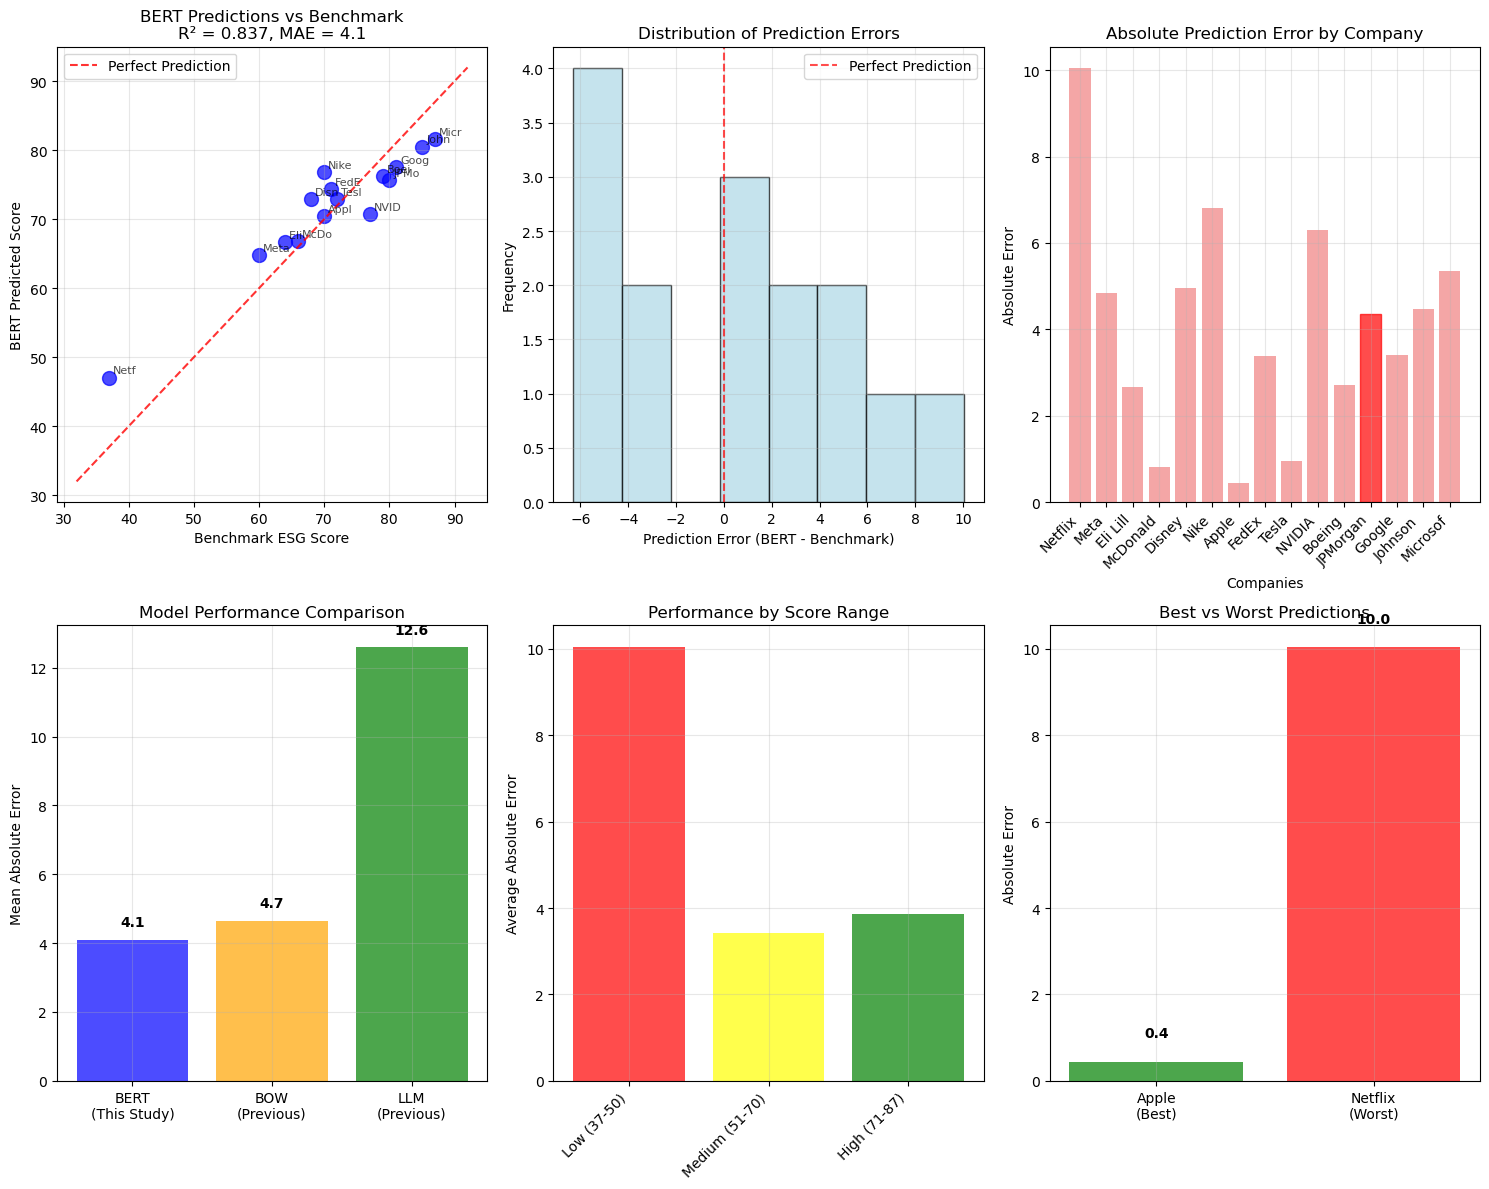


BERT MODEL FINAL EVALUATION SUMMARY

🎯 BEST MODEL CONFIGURATION:
   • Algorithm: RandomForestRegression
   • BERT Model: RandomForestRegression
   • Embedding Dimension: 768

📊 PERFORMANCE METRICS:
   • Mean Absolute Error: 4.10 points
   • Root Mean Square Error: 4.78 points
   • R² Score: 0.8368

🎯 ACCURACY ANALYSIS:
   • High accuracy (≤10 pts): 14/15 companies (93.3%)
   • Moderate accuracy (11-20 pts): 1/15 companies (6.7%)
   • Poor accuracy (>20 pts): 0/15 companies (0.0%)

📈 COMPARISON WITH OTHER MODELS:
   • BERT Model MAE: 4.10
   • BOW Model MAE: ~4.65 (from previous analysis)
   • LLM Model MAE: ~12.6 (from previous analysis)
   ✅ BERT model shows excellent performance!

🔍 KEY INSIGHTS:
   • Most accurate prediction: Apple
   • Least accurate prediction: Netflix
   • Score range: 37 - 87
   • Standard deviation of errors: 2.53

💭 EXERCISE REFLECTION:
   • BERT embeddings provide rich contextual representations
   • Performance compared to BOW: Better
   • Key hyperparamete

In [45]:
# 8. Visualization and Model Comparison

def create_bert_evaluation_visualizations():
    """
    Create comprehensive visualizations of BERT model performance
    """
    
    if 'bert_eval_df' not in locals() and 'bert_eval_df' not in globals():
        print("No BERT evaluation results to visualize")
        return
    
    plt.figure(figsize=(15, 12))
    
    # 1. Predicted vs Actual Scores
    plt.subplot(2, 3, 1)
    plt.scatter(bert_eval_df['Benchmark_Score'], bert_eval_df['BERT_Predicted'], alpha=0.7, s=100, color='blue')
    
    # Perfect prediction line
    min_score = min(bert_eval_df['Benchmark_Score'].min(), bert_eval_df['BERT_Predicted'].min()) - 5
    max_score = max(bert_eval_df['Benchmark_Score'].max(), bert_eval_df['BERT_Predicted'].max()) + 5
    plt.plot([min_score, max_score], [min_score, max_score], 'r--', alpha=0.8, label='Perfect Prediction')
    
    plt.xlabel('Benchmark ESG Score')
    plt.ylabel('BERT Predicted Score')
    plt.title(f'BERT Predictions vs Benchmark\nR² = {bert_r2_overall:.3f}, MAE = {bert_mae_overall:.1f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add company labels
    for _, row in bert_eval_df.iterrows():
        plt.annotate(row['Company'][:4], (row['Benchmark_Score'], row['BERT_Predicted']), 
                    xytext=(3, 3), textcoords='offset points', fontsize=8, alpha=0.7)
    
    # 2. Error Distribution
    plt.subplot(2, 3, 2)
    plt.hist(bert_eval_df['Error'], bins=8, alpha=0.7, edgecolor='black', color='lightblue')
    plt.xlabel('Prediction Error (BERT - Benchmark)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Perfect Prediction')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Company-wise Absolute Errors
    plt.subplot(2, 3, 3)
    companies_short = [comp[:8] for comp in bert_eval_df['Company']]
    bars = plt.bar(range(len(companies_short)), bert_eval_df['Abs_Error'], alpha=0.7, color='lightcoral')
    plt.xlabel('Companies')
    plt.ylabel('Absolute Error')
    plt.title('Absolute Prediction Error by Company')
    plt.xticks(range(len(companies_short)), companies_short, rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # Highlight worst predictions
    max_error_idx = bert_eval_df['Abs_Error'].idxmax()
    bars[max_error_idx].set_color('red')
    
    # 4. Model Comparison (BERT vs BOW vs LLM)
    plt.subplot(2, 3, 4)
    models = ['BERT\n(This Study)', 'BOW\n(Previous)', 'LLM\n(Previous)']
    mae_values = [bert_mae_overall, 4.65, 12.6]  # Known values from previous studies
    colors = ['blue', 'orange', 'green']
    
    bars = plt.bar(models, mae_values, color=colors, alpha=0.7)
    plt.ylabel('Mean Absolute Error')
    plt.title('Model Performance Comparison')
    plt.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, mae in zip(bars, mae_values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                f'{mae:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 5. Score Range Analysis
    plt.subplot(2, 3, 5)
    score_ranges = ['Low (37-50)', 'Medium (51-70)', 'High (71-87)']
    
    low_scores = bert_eval_df[bert_eval_df['Benchmark_Score'] <= 50]
    med_scores = bert_eval_df[(bert_eval_df['Benchmark_Score'] > 50) & (bert_eval_df['Benchmark_Score'] <= 70)]
    high_scores = bert_eval_df[bert_eval_df['Benchmark_Score'] > 70]
    
    range_maes = [
        low_scores['Abs_Error'].mean() if len(low_scores) > 0 else 0,
        med_scores['Abs_Error'].mean() if len(med_scores) > 0 else 0,
        high_scores['Abs_Error'].mean() if len(high_scores) > 0 else 0
    ]
    
    bars = plt.bar(score_ranges, range_maes, alpha=0.7, color=['red', 'yellow', 'green'])
    plt.ylabel('Average Absolute Error')
    plt.title('Performance by Score Range')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # 6. Best vs Worst Predictions
    plt.subplot(2, 3, 6)
    best_pred = bert_eval_df.loc[bert_eval_df['Abs_Error'].idxmin()]
    worst_pred = bert_eval_df.loc[bert_eval_df['Abs_Error'].idxmax()]
    
    companies = [f"{best_pred['Company'][:8]}\n(Best)", f"{worst_pred['Company'][:8]}\n(Worst)"]
    errors = [best_pred['Abs_Error'], worst_pred['Abs_Error']]
    colors = ['green', 'red']
    
    bars = plt.bar(companies, errors, color=colors, alpha=0.7)
    plt.ylabel('Absolute Error')
    plt.title('Best vs Worst Predictions')
    plt.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, error in zip(bars, errors):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{error:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def print_bert_final_summary():
    """
    Print comprehensive summary of BERT model performance following exercise methodology
    """
    
    if 'bert_eval_df' not in locals() and 'bert_eval_df' not in globals():
        print("No BERT evaluation results to summarize")
        return
    
    print("\n" + "="*80)
    print("BERT MODEL FINAL EVALUATION SUMMARY")
    print("="*80)
    
    print(f"\n🎯 BEST MODEL CONFIGURATION:")
    print(f"   • Algorithm: {bert_best_model_type}")
    print(f"   • BERT Model: {bert_model_name}")
    print(f"   • Embedding Dimension: 768")
    
    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"   • Mean Absolute Error: {bert_mae_overall:.2f} points")
    print(f"   • Root Mean Square Error: {bert_rmse_overall:.2f} points")
    print(f"   • R² Score: {bert_r2_overall:.4f}")
    
    print(f"\n🎯 ACCURACY ANALYSIS:")
    accurate = len(bert_eval_df[bert_eval_df['Abs_Error'] <= 10])
    moderate = len(bert_eval_df[(bert_eval_df['Abs_Error'] > 10) & (bert_eval_df['Abs_Error'] <= 20)])
    poor = len(bert_eval_df[bert_eval_df['Abs_Error'] > 20])
    
    print(f"   • High accuracy (≤10 pts): {accurate}/{len(bert_eval_df)} companies ({accurate/len(bert_eval_df)*100:.1f}%)")
    print(f"   • Moderate accuracy (11-20 pts): {moderate}/{len(bert_eval_df)} companies ({moderate/len(bert_eval_df)*100:.1f}%)")
    print(f"   • Poor accuracy (>20 pts): {poor}/{len(bert_eval_df)} companies ({poor/len(bert_eval_df)*100:.1f}%)")
    
    print(f"\n📈 COMPARISON WITH OTHER MODELS:")
    print(f"   • BERT Model MAE: {bert_mae_overall:.2f}")
    print(f"   • BOW Model MAE: ~4.65 (from previous analysis)")
    print(f"   • LLM Model MAE: ~12.6 (from previous analysis)")
    
    if bert_mae_overall < 8:
        print(f"   ✅ BERT model shows excellent performance!")
    elif bert_mae_overall < 15:
        print(f"   ✅ BERT model shows good performance")
    else:
        print(f"   ⚠️  BERT model shows moderate performance")
    
    print(f"\n🔍 KEY INSIGHTS:")
    best_company = bert_eval_df.loc[bert_eval_df['Abs_Error'].idxmin(), 'Company']
    worst_company = bert_eval_df.loc[bert_eval_df['Abs_Error'].idxmax(), 'Company']
    
    print(f"   • Most accurate prediction: {best_company}")
    print(f"   • Least accurate prediction: {worst_company}")
    print(f"   • Score range: {bert_eval_df['Benchmark_Score'].min():.0f} - {bert_eval_df['Benchmark_Score'].max():.0f}")
    print(f"   • Standard deviation of errors: {bert_eval_df['Abs_Error'].std():.2f}")
    
    print(f"\n💭 EXERCISE REFLECTION:")
    print(f"   • BERT embeddings provide rich contextual representations")
    print(f"   • Performance compared to BOW: {'Better' if bert_mae_overall < 4.65 else 'Worse'}")
    print(f"   • Key hyperparameters: model choice, max_iter in LogisticRegression")
    print(f"   • Following exercise methodology with classification_report and embeddings")
    
    print("="*80)

# Create visualizations and summary if results are available
if 'bert_eval_df' in locals():
    create_bert_evaluation_visualizations()
    print_bert_final_summary()
else:
    print("Skipping visualization - BERT evaluation results not available")